# Data Representation Take-home Tech Assessment (TTA)

Objective: 
1. a time series of <u>consistent</u> Google Trends data from 2017 till the present with <u>hourly interval</u>

Source Data
1. a time series of <u>weekly-consistent</u> Google Trends data starting in 2017 and continuing up to the present, with <u>hourly intervals</u>
2. a time series of <u>yearly-consistent</u> Google Trends data starting in 2017 and continuing up to the present, with <u>weekly intervals</u>
3. a time series of <u>consistent</u> Google Trends data starting in 2017 and continuing up to the present, with <u>monthly intervals</u>

## 1.0 Imports

In [1]:
import pandas as pd

from pathlib import Path

## 1.0 Read the data

In [2]:
input_folder = Path('X:/EonLabs_TTA/input')

hourly_data_filename = 'hourly_data.csv'
weekly_data_filename = 'weekly_data.csv'
monthly_data_filename = 'monthly_data.csv'

In [3]:
hourly_df = pd.read_csv(input_folder/hourly_data_filename)
weekly_df = pd.read_csv(input_folder/weekly_data_filename)
monthly_df = pd.read_csv(input_folder/monthly_data_filename)

In [4]:
# format the date values
hourly_df['date'] = pd.to_datetime(hourly_df['date'])
weekly_df['date'] = pd.to_datetime(weekly_df['date'])
monthly_df['date'] = pd.to_datetime(monthly_df['date'])

In [5]:
hourly_df.head()

,time_hour,value_hour,date
0,1483228800,30,2017-01-01 00:00:00
1,1483232400,34,2017-01-01 01:00:00
2,1483236000,33,2017-01-01 02:00:00
3,1483239600,43,2017-01-01 03:00:00
4,1483243200,32,2017-01-01 04:00:00


In [6]:
weekly_df.head()

,time_week,value_week,date
0,1483228800,100,2017-01-01
1,1483833600,84,2017-01-08
2,1484438400,63,2017-01-15
3,1485043200,56,2017-01-22
4,1485648000,60,2017-01-29


In [7]:
monthly_df.head()

,time_month,value_month,date
0,1483228800,6,2017-01-01
1,1485907200,6,2017-02-01
2,1488326400,7,2017-03-01
3,1491004800,6,2017-04-01
4,1493596800,15,2017-05-01


<AxesSubplot:xlabel='date'>

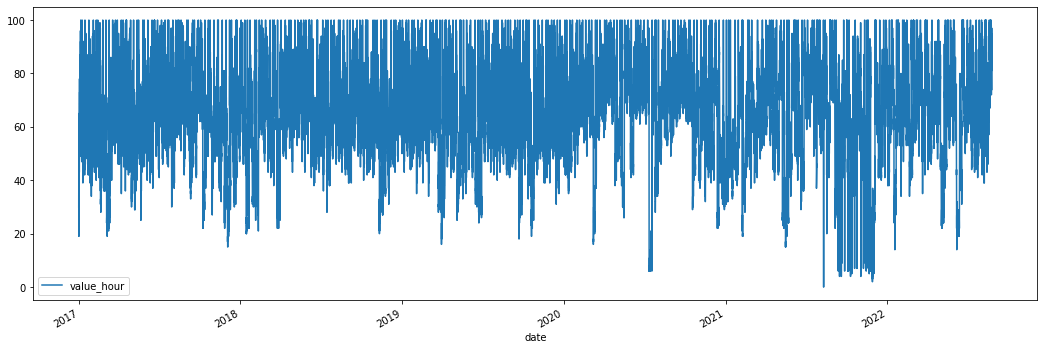

In [8]:
hourly_df.plot.line(x='date', y='value_hour', figsize=(18,6))

<AxesSubplot:xlabel='date'>

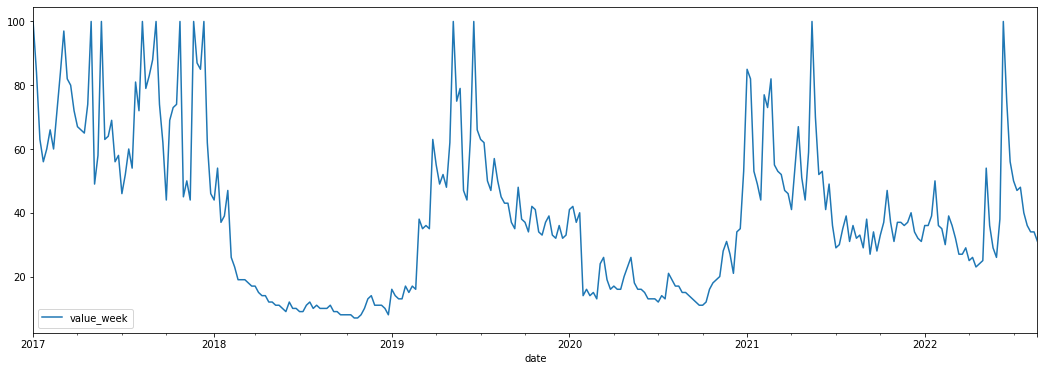

In [9]:
weekly_df.plot.line(x='date', y='value_week', figsize=(18,6))

<AxesSubplot:xlabel='date'>

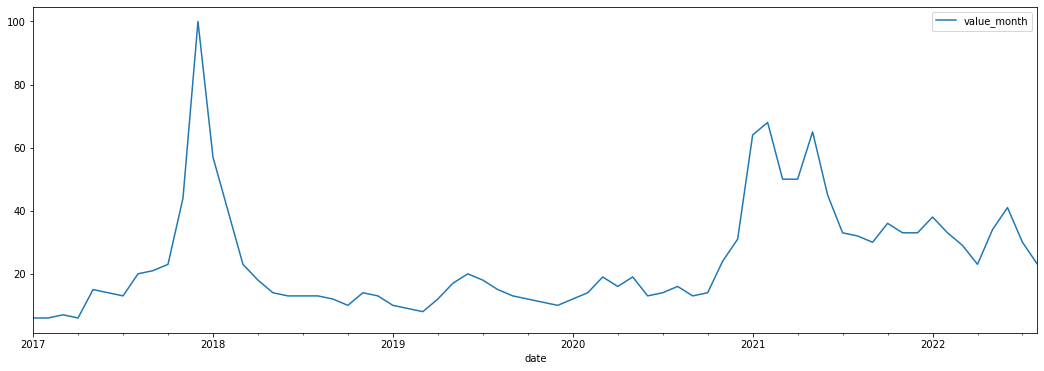

In [10]:
monthly_df.plot.line(x='date', y='value_month', figsize=(18,6))

In [11]:
# min and max values of each given time series
print(max(hourly_df['value_hour']), min(hourly_df['value_hour']))
print(max(weekly_df['value_week']), min(weekly_df['value_week']))
print(max(monthly_df['value_month']), min(monthly_df['value_month']))

100 0
100 7
100 6


## 2.0 Deriviation - consistent hourly data

What I am going to do is to:
1. use the monthly data to calculate the consistent weekly data (year by year)
2. use the result from step 1 to calculate consistent hourly data (week by week)

### 2.1 Make the weekly data consistent

In [12]:
# extract the year value from the date
# weekly_df['year'] = weekly_df['date'].dt.isocalendar().year # this returns the ISO year which is different from what people commonly use
weekly_df['year'] = weekly_df['date'].dt.year
monthly_df['year'] = monthly_df['date'].dt.year

In [13]:
# calculate the conversion ratios in year by year levels
value_year_consistent = monthly_df[['year', 'value_month']].groupby(['year'])\
    .sum().reset_index().rename(columns={'value_month': 'value_year_consistent'})

value_year_shares = weekly_df[['year', 'value_week']].groupby(['year'])\
    .sum().reset_index().rename(columns={'value_week': 'value_year_shares'})

In [14]:
stage2_1_ratio = value_year_consistent.merge(value_year_shares)
stage2_1_ratio['ratio2_1'] = stage2_1_ratio['value_year_consistent']/stage2_1_ratio['value_year_shares']
stage2_1_ratio.head()

,year,value_year_consistent,value_year_shares,ratio2_1
0,2017,275,3795,0.072464
1,2018,240,782,0.306905
2,2019,155,2249,0.068920
3,2020,205,1057,0.193945
4,2021,539,2405,0.224116


In [15]:
# apply the ratio to get consistent weekly data
weekly_df = weekly_df.merge(stage2_1_ratio[['year','ratio2_1']])
weekly_df['value_week_consistent'] = weekly_df['value_week'] * weekly_df['ratio2_1'] * (52/12) # compensate for 52 weeks and 12 months per year

<AxesSubplot:xlabel='date'>

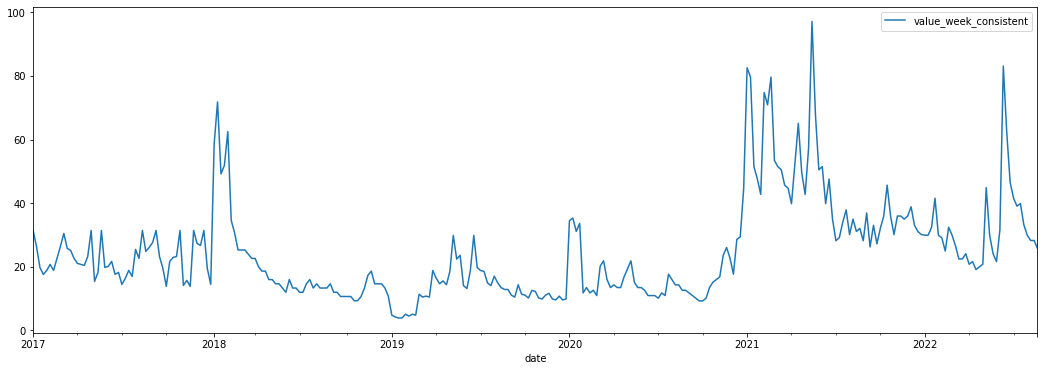

In [16]:
weekly_df.plot.line(x='date', y='value_week_consistent', figsize=(18,6))

### 2.2 Make the hourly data consistent

In [17]:
# extract the year and week values from the date
hourly_df['year'] = hourly_df['date'].dt.year
hourly_df['week_of_year'] = hourly_df['date'].dt.isocalendar().week # ISO week is 1 week off from the common weeks, but (month, week) pair is still a unique key...

weekly_df['year'] = weekly_df['date'].dt.year
weekly_df['week_of_year'] = weekly_df['date'].dt.isocalendar().week

In [18]:
# calculate the conversion ratios in week by week levels
value_week_consistent = weekly_df[['year', 'week_of_year','value_week_consistent']].groupby(['year', 'week_of_year'])\
    .sum().reset_index()

value_week_shares = hourly_df[['year', 'week_of_year', 'value_hour']].groupby(['year', 'week_of_year'])\
    .sum().reset_index().rename(columns={'value_hour': 'value_week_shares'})

In [19]:
stage2_2_ratio = value_week_consistent.merge(value_week_shares)
stage2_2_ratio['ratio2_2'] = stage2_2_ratio['value_week_consistent']/stage2_2_ratio['value_week_shares']
stage2_2_ratio.head()

,year,week_of_year,value_week_consistent,value_week_shares,ratio2_2
0,2017,1,26.376812,11176,0.002360
1,2017,2,19.782609,10621,0.001863
2,2017,3,17.584541,10958,0.001605
3,2017,4,18.840580,10794,0.001745
4,2017,5,20.724638,10534,0.001967


In [20]:
# apply the ratio to get consistent hourly data
hourly_df = hourly_df.merge(stage2_2_ratio[['year','week_of_year','ratio2_2']])
hourly_df['value_hour_consistent'] = hourly_df['value_hour'] * hourly_df['ratio2_2'] * (24*7) # compensate for 7*24 hours per week


<AxesSubplot:xlabel='date'>

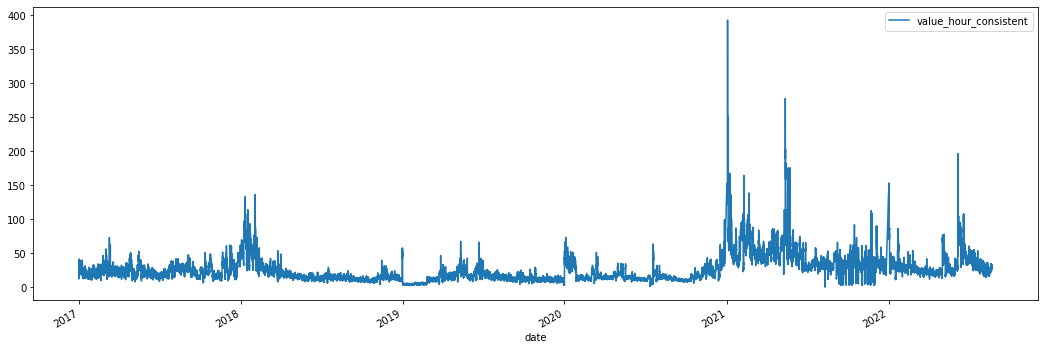

In [21]:
hourly_df.plot.line(x='date', y='value_hour_consistent', figsize=(18,6))

## 3.0 Quick Check

Spent some time confirming the idea was probably implemented as correctly as I thought.

The idea is the total should stay the same when distributing from years to hours(before I compensate for the unit relationships)

In [22]:
print(' total value of monthly data: ', monthly_df['value_month'].sum(), 
'\n',
'total value of derived weekly data: ', weekly_df['value_week_consistent'].sum() / (52/12), 
'\n',
'total value of derived weekly data: ', hourly_df['value_hour_consistent'].sum() / (52/12) / (24*7)
)

 total value of monthly data:  1665 
 total value of derived weekly data:  1665.0000000000002 
 total value of derived weekly data:  1664.9999999999995


Looks Good!

## 4.0 Save the result

In [23]:
output_folder = Path('X:/EonLabs_TTA/output')

output_filename = 'consistent_hourly_data.csv'

In [24]:
consistent_hourly_df = hourly_df[['time_hour', 'value_hour_consistent', 'date']].copy()\
    .rename(columns={'value_hour_consistent': 'value_hour'})

In [25]:
consistent_hourly_df.to_csv(output_folder/output_filename, index=False)